<a href="https://colab.research.google.com/github/coryamanda/datarobot-api-lab/blob/main/DataRobot_API_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Loan Default

## Overview

Not all customers are created equal.  Some present more risk than others. Our goal today is to build a model to understand the default risk of our 
customers.  This will help us understand which loans are going to be most 
profitable, and worth of lending money to.  In this example, DataRobot will try to model whether a customer will default on a funded loan. 

## Prerequisites
In order to run this notebook yourself, you will need the following:

- The datasets required for this notebook. These are in the same directory as this notebook.
- A DataRobot API token. You can find your API token by logging into the DataRobot Web User Interface and looking in your `Profile`.

## Set Up
This example assumes that the DataRobot Python client package has been installed and configured with the credentials of a DataRobot user with API access permissions.

In [10]:
!pip install datarobot==2.21.5

In [68]:
token = ""

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import yaml
import datarobot as dr
from google.colab import drive
import requests
import pprint as pp

In [13]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
!sudo apt-get install -y graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


## Get DataRobot API Credentials

This assumes that you already have DataRobot installed.  



In [69]:
token = ""
endpoint = "https://app2.datarobot.com/api/v2"

In [16]:
client = dr.Client(token, endpoint='https://app.datarobot.com/api/v2')

## DataRobot API Documentation

* [API Docs](https://app2.datarobot.com/apidocs/) requires login to the platform
* [Python Client](https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.22.1/)
* [R Client](https://cran.r-project.org/web/packages/datarobot/index.html)

Other resources - [DataRobot Github Communtiy](https://github.com/datarobot-community)

## Get Data


### From Athena 

For this lab, we will use a local csv to get moving, but do see this article on how to leverage [Athena](https://community.datarobot.com/t5/general-knowledge-base/datarobot-machine-learning-with-aws-athena-and-parquet-data/ta-p/1063), as well as the code snippet below on how to add Athena as a data source


In [ ]:
## example on how to connect to athena from datarobot

# with open("/content/gdrive/My Drive/datarobot-api/athena_creds.yaml", "r") as fi:
#     athena_creds = yaml.load(fi)

# athena_data_driver = [d for d in dr.DataDriver.list() if "Athena" in str(d)].pop()

####### these steps only need to be done once
## this step only needs to be done once.  Once the data store created it will persist
# athena_datastore = dr.DataStore.create(
#     data_store_type = "jdbc", 
#     canonical_name = "Athena"
#     driver_id = athena_data_driver.id
#     jdbc_url = athena_creds["URL"]
# )

# ## additionally, once the datasource is created it will persist as well
# ## set parameters for the datasource
# params = dr.DataSourceParameters(
#     data_store_id=athena_datastore.id,
#     query='SELECT * FROM cfds_athena_demo.lending_club_parquet;'
# )

# ## create the datasource within the datastore
# data_source = dr.DataSource.create(
#     data_source_type='jdbc',
#     canonical_name='LC Parquet',
#     params=params)
#######

# ## create the project from the data sourced
# project = dr.Project.create_from_data_source(
#     data_source_id = data_source.id,
#     username = athena_creds["AWSAccessKeyId"], 
#     password = athena_creds["AWSSecretKey"],
#     project_name = "Lending Club Parquet"
# )



In [17]:
df = pd.read_csv(
    "/content/gdrive/My Drive/Colab Notebooks/10K_Lending_Club_Loans.csv",
    encoding="latin-1"
    )

In [18]:
df["is_bad"].describe()

count    10000.000000
mean         0.129500
std          0.335769
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: is_bad, dtype: float64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   is_bad                       10000 non-null  int64  
 1   loan_amnt                    10000 non-null  int64  
 2   funded_amnt                  10000 non-null  int64  
 3   term                         10000 non-null  object 
 4   int_rate                     10000 non-null  object 
 5   installment                  10000 non-null  float64
 6   grade                        10000 non-null  object 
 7   sub_grade                    10000 non-null  object 
 8   emp_title                    9408 non-null   object 
 9   emp_length                   9741 non-null   object 
 10  home_ownership               10000 non-null  object 
 11  annual_inc                   9999 non-null   float64
 12  verification_status          10000 non-null  object 
 13  pymnt_plan       

## Create a DataRobot Project

In [20]:
project = dr.Project.create(df, project_name = "lending club example")

In [25]:
project

Project(lending club example)

## Start modeling

Once the code is executed below, control is returned once it is established that DataRobot will be able to start modeling on the target variable.  This kicks off 
* Data Characterization 
* Exploratory Data Analysis
* Blueprint preparation (how DataRobot will use the features and target to make predictiosn)

In [21]:
## set the target and start modeling
project.set_target("is_bad")
## increase the number of workers / how many models you can train at once. 
project.set_worker_count(-1)

Project(lending club example)

## DataRobot project setup

Since we are using DataRobot default recommendations for everything, that means we allowed DataRobot to pick:
* validation strategy
* identify problem type (regression of classification)
* optimization metric

If we wanted to choose this ourselves, we certainly could.  

In [22]:
project.partition

{'cv_method': 'stratified',
 'holdout_pct': 20.0,
 'reps': 5,
 'validation_type': 'CV'}

In [31]:
project.target_type

'Binary'

In [32]:
project.metric

'LogLoss'

## Anatomy of a DataRobot project

A project is composed of 
* features
* feature lists 
* blueprints
* models

In [23]:
print("project name: {} \nproject id: {}".format(project.project_name, project.id))
for i in project.get_status().items():
    print("{}: {}".format(i[0],i[1]))

project name: lending club example 
project id: 5fc8e4fa754dc23d9569fcfe
autopilot_done: False
stage_description: Ready for modeling
stage: modeling


### Features 

The features of your dataset.  To grab all the features of your dataset, simply use the `get_features` method of the project.

A feature from a project's dataset
  
These are features either included in the originally uploaded dataset or added to it via
feature transformations.  

The ``min``, ``max``, ``mean``, ``median``, and ``std_dev`` attributes provide information about
the distribution of the feature in the EDA sample data.  For non-numeric features or features
created prior to these summary statistics becoming available, they will be None.  For features
where the summary statistics are available, they will be in a format compatible with the data
type, i.e. date type features will have their summary statistics expressed as ISO-8601
formatted date strings.


In [24]:
features = project.get_features()
features[0:5]

[Feature(mths_since_last_delinq),
 Feature(inq_last_6mths),
 Feature(grade),
 Feature(annual_inc),
 Feature(total_acc)]

In [25]:
descriptive_stats = [(f.name, f.min, f.max, f.mean, f.median, f.na_count, f.unique_count) for f in features]
descriptive_stats = pd.DataFrame(descriptive_stats,
                                 columns = ["name", "min", "max", "mean", "median", "na", "cardinality"]
                                 )

In [26]:
descriptive_stats.head()


,name,min,max,mean,median,na,cardinality
0,mths_since_last_delinq,0,120,36.0003,34,5076.0,91
1,inq_last_6mths,0,25,1.078,1,4.0,20
2,grade,None,None,None,None,0.0,7
3,annual_inc,4080,900000,68609.8,58479,1.0,1614
4,total_acc,1,90,22.12,20,4.0,74


Since we have started modeling, we can pull out the feature importance from the data tab and provide a plot.  

In [27]:

feature_importance = pd.DataFrame([(f.name, f.importance) for f in features], columns = ["feature", "importance"]).sort_values("importance", ascending = False).dropna()
feature_importance.set_index("feature").iloc[:-1].clip(0)


,importance
feature,
is_bad,1.000000
int_rate,0.035801
grade,0.030569
sub_grade,0.027335
term,0.020422
revol_util,0.012775
title,0.009576
purpose,0.007647
desc,0.006874


### Feature lists

In DataRobot a FeatureList is a set of features to be used in model.  By default, DataRobot creates several FeatureLists through the course of autopilot.  

In [28]:
featurelists = project.get_featurelists()

In [29]:
featurelists

[Featurelist(Raw Features),
 Featurelist(Informative Features),
 Featurelist(Univariate Selections)]

In [30]:
informative_features = featurelists[1]
informative_features.features

['is_bad',
 'loan_amnt',
 'funded_amnt',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line (Year)',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'earliest_cr_line (Month)',
 'earliest_cr_line (Day of Week)']

### Blueprints

The set of computation paths that a dataset passes through before producing predictions from data is called a Blueprint. A Blueprint can be trained on a dataset to generate a model.

In [31]:
blueprints = project.get_blueprints()

In [32]:
len(blueprints)

95

In [33]:
blueprints

[Blueprint(ExtraTrees Classifier (Gini)),
 Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping),
 Blueprint(Keras Wide Residual Neural Network Classifier using Training Schedule (1 Layer: 1536 Units)),
 Blueprint(Anomaly Detection Blender),
 Blueprint(Local Outlier Factor Anomaly Detection),
 Blueprint(Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance)),
 Blueprint(Anomaly Detection with Supervised Learning (XGB)),
 Blueprint(TensorFlow Deep Learning Classifier),
 Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping and Unsupervised Learning Features),
 Blueprint(Isolation Forest Anomaly Detection),
 Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping (learning rate =0.01)),
 Blueprint(eXtreme Gradient Boosted Trees Classifier with Early Stopping (learning rate =0.01)),
 Blueprint(Dropout Additive Regression Trees Classifier  (15 leaves)),
 Blueprint(Eureqa Generalized Additive Model Classifier (1000 Generations)),
 

In [35]:
blueprint = blueprints[0]
blueprint

Blueprint(ExtraTrees Classifier (Gini))

We can also access the full set of processing steps for a given Blueprint.

In [36]:
blueprint.processes

['One-Hot Encoding',
 'Univariate credibility estimates with ElasticNet',
 'Missing Values Imputed',
 'Search for differences',
 'Search for ratios',
 'Converter for Text Mining',
 'Auto-Tuned Word N-Gram Text Modeler using token occurrences',
 'Feature Selection for dimensionality reduction',
 'ExtraTrees Classifier (Gini)']

### Models

A trained Blueprint using a specific FeatureList

In [37]:
models = project.get_models()

In [38]:
models

[Model('Gradient Boosted Trees Classifier with Early Stopping'),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Generalized Additive2 Model'),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping and Unsupervised Learning Features'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Gradient Boosted Greedy Trees Classifier with Early Stopping'),
 Model('Generalized Additive2 Model'),
 Model('Gradient Boosted Greedy Trees Classifier with Early Stopping'),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping and Unsupervised Learning Features'),
 Model('RandomForest Classifier (Entropy)'),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Gradient Boosted T

In [45]:
model = models[0]

In [69]:
model

Model('Gradient Boosted Trees Classifier with Early Stopping')

In [58]:
model.processes

['Ordinal encoding of categorical variables',
 'Missing Values Imputed',
 'Converter for Text Mining',
 'Auto-Tuned Word N-Gram Text Modeler using token occurrences',
 'Gradient Boosted Trees Classifier with Early Stopping']

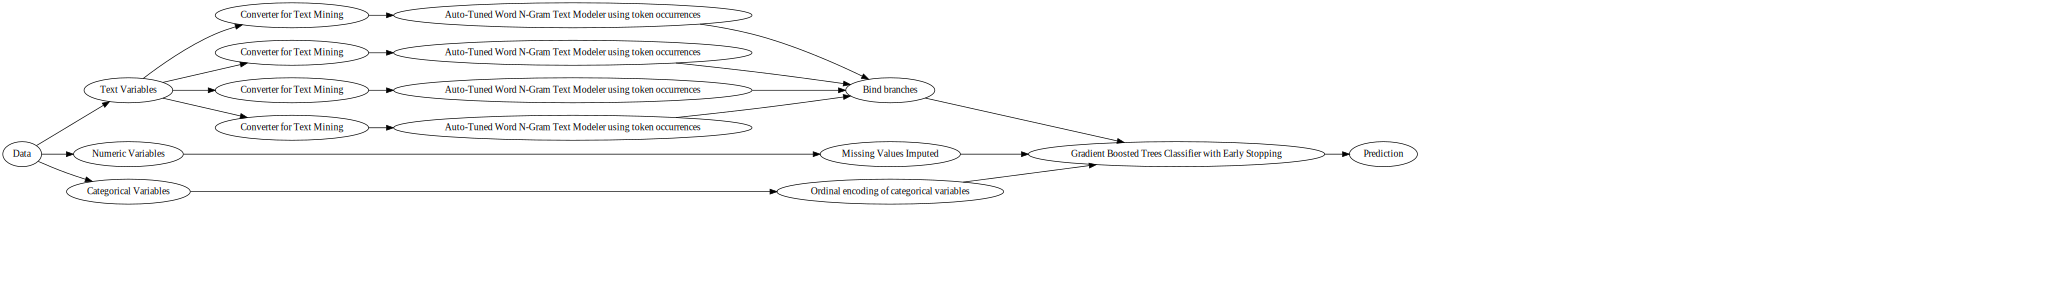

In [46]:
with open("graph.dot", "w") as f:
  f.write(model.get_model_blueprint_chart().to_graphviz())
!dot -Tsvg graph.dot -o graph.svg -Gdpi=50
from IPython.core.display import SVG
SVG(filename='graph.svg')

In [72]:
model.star_model()

In [55]:
feature_impact = pd.DataFrame(model.get_or_request_feature_impact()).set_index("featureName")["impactUnnormalized"].sort_values(ascending = False)
feature_impact

featureName
desc                              0.018194
annual_inc                        0.013130
int_rate                          0.012971
title                             0.012084
term                              0.008825
grade                             0.005665
inq_last_6mths                    0.004245
revol_util                        0.003257
open_acc                          0.001863
loan_amnt                         0.001850
zip_code                          0.001737
funded_amnt                       0.001193
earliest_cr_line (Year)           0.001159
revol_bal                         0.001143
mths_since_last_record            0.001136
emp_title                         0.001049
sub_grade                         0.000983
purpose                           0.000902
dti                               0.000651
addr_state                        0.000641
installment                       0.000618
mths_since_last_delinq            0.000472
earliest_cr_line (Month)          0.000463

Other things availabe
* Details from ROC curve table
* Feature Effects

## Leaderboard

In [77]:
project.get_leaderboard_ui_permalink()

'https://app.datarobot.com/projects/5fc875dad45c89e413556c1b/models'

In [47]:
def build_leaderboard(project, metric=project.metric):
    leaderboard = []
    models = project.get_models()
    for model in models:
        temp = model.metrics[metric]
        temp["Model"] = str(model)
        temp["featurelist"] = model.featurelist_name
        temp["sample_pct"] = model.sample_pct
        leaderboard.append(temp)
    leaderboard_df = pd.DataFrame(leaderboard)[["Model", "featurelist", "sample_pct", "validation", "crossValidation", "holdout"]]
    return leaderboard_df

In [48]:
build_leaderboard(project, "AUC")

,Model,featurelist,sample_pct,validation,crossValidation,holdout
0,Model('eXtreme Gradient Boosted Trees Classifi...,Informative Features,80.0,0.67450,0.706810,NaN
1,Model('Gradient Boosted Trees Classifier with ...,Informative Features,64.0,0.66533,0.698568,NaN
2,Model('AVG Blender'),Informative Features,64.0,0.66728,0.704052,NaN
3,Model('ENET Blender'),Informative Features,64.0,0.66728,0.704082,NaN
4,Model('eXtreme Gradient Boosted Trees Classifi...,Informative Features,64.0,0.66860,0.698340,NaN
...,...,...,...,...,...,...
85,Model('Keras Slim Residual Neural Network Clas...,Informative Features,16.0,0.61947,NaN,NaN
86,Model('Naive Bayes combiner classifier'),Informative Features,16.0,0.62699,NaN,NaN
87,Model('Logistic Regression'),Informative Features,16.0,0.60225,NaN,NaN
88,Model('Decision Tree Classifier (Gini)'),Informative Features,16.0,0.60790,NaN,NaN


In [50]:
build_leaderboard(project, "LogLoss").sort_values("validation", ascending=True)

,Model,featurelist,sample_pct,validation,crossValidation,holdout
0,Model('eXtreme Gradient Boosted Trees Classifi...,Informative Features,80.0,0.36457,0.355778,NaN
1,Model('Gradient Boosted Trees Classifier with ...,Informative Features,64.0,0.36501,0.358322,NaN
2,Model('AVG Blender'),Informative Features,64.0,0.36508,0.357008,NaN
3,Model('ENET Blender'),Informative Features,64.0,0.36509,0.356978,NaN
4,Model('eXtreme Gradient Boosted Trees Classifi...,Informative Features,64.0,0.36544,0.357964,NaN
...,...,...,...,...,...,...
85,Model('Keras Slim Residual Neural Network Clas...,Informative Features,16.0,0.42797,NaN,NaN
86,Model('Naive Bayes combiner classifier'),Informative Features,16.0,0.43701,NaN,NaN
87,Model('Logistic Regression'),Informative Features,16.0,0.46503,NaN,NaN
88,Model('Decision Tree Classifier (Gini)'),Informative Features,16.0,0.48316,NaN,NaN


### Create a custom feature list


When we get the list of FeatureLists in this project, we start with the four DataRobot created for us. 

In [41]:
project.get_featurelists()

[Featurelist(Raw Features),
 Featurelist(Informative Features),
 Featurelist(Univariate Selections),
 Featurelist(DR Reduced Features M79)]

Now we can manually grab the 20 most impactful features from our previous top model.

In [52]:
#manually define a new feature list
new_list_name = "best_model_top_20"
features_to_include = feature_impact[0:20].index.tolist()
features_to_include

['desc',
 'annual_inc',
 'int_rate',
 'title',
 'term',
 'grade',
 'inq_last_6mths',
 'revol_util',
 'open_acc',
 'loan_amnt',
 'zip_code',
 'funded_amnt',
 'earliest_cr_line (Year)',
 'revol_bal',
 'mths_since_last_record',
 'emp_title',
 'sub_grade',
 'purpose',
 'dti',
 'addr_state']

Then we can add that Feature List to the project and run individual models or full Autopilot again if we want to.

In [53]:
new_list = project.create_featurelist(new_list_name, features_to_include)
project.get_featurelists()

[Featurelist(Raw Features),
 Featurelist(Informative Features),
 Featurelist(Univariate Selections),
 Featurelist(DR Reduced Features M79),
 Featurelist(best_model_top_20)]

In [54]:
#project.start_autopilot(new_list.id) #This runs full Autopilot again
model_job_id = model.train( #This will train an individual model with the new list
    sample_pct=64,
    featurelist_id=new_list.id,
    scoring_type=dr.SCORING_TYPE.cross_validation,
)

In [ ]:
project.unlock_holdout()

Project(lending club example)

In [ ]:
build_leaderboard(project)

,Model,featurelist,sample_pct,validation,crossValidation,holdout
0,Model('eXtreme Gradient Boosted Trees Classifi...,DR Reduced Features M26,80.0,0.36436,0.355948,0.36165
1,Model('eXtreme Gradient Boosted Trees Classifi...,Informative Features - Leakage Removed,64.0,0.36505,0.357610,0.36174
2,Model('AVG Blender'),None,64.0,0.36527,0.356718,0.36056
3,Model('eXtreme Gradient Boosted Trees Classifi...,DR Reduced Features M26,100.0,0.36546,0.355548,0.36181
4,Model('Light Gradient Boosted Trees Classifier...,Informative Features - Leakage Removed,64.0,0.36573,0.358378,0.36158
5,Model('Generalized Additive2 Model'),Informative Features - Leakage Removed,64.0,0.36787,0.360250,0.36271
6,Model('eXtreme Gradient Boosted Trees Classifi...,DR Reduced Features M26,64.0,0.36808,0.357460,0.36190
7,Model('Light Gradient Boosted Trees Classifier...,Informative Features - Leakage Removed,32.0,0.36965,NaN,0.36951
8,Model('eXtreme Gradient Boosted Trees Classifi...,DR Reduced Features M26,32.0,0.37192,NaN,0.37276
9,Model('Gradient Boosted Trees Classifier'),Informative Features - Leakage Removed,64.0,0.37208,0.362268,0.36602


### Hyperparameter Tuning


Hyperparameter tuning is a common use case for the API. To start, we'll create a new tuning session and understand which tasks are available for tuning within this Blueprint. 

In [95]:
tune = model.start_advanced_tuning_session()
tasks = tune.get_task_names()
tasks


['Gradient Boosted Trees Classifier with Early Stopping',
 'Missing Values Imputed',
 'Ordinal encoding of categorical variables']

Next, we can understand which components of each step are available for tuning. 

In [98]:
for task in tasks:
    pp.pprint(task)
    pp.pprint(tune.get_parameter_names(task))
    print()

'Gradient Boosted Trees Classifier with Early Stopping'
['learning_rate',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'min_samples_leaf',
 'min_samples_split',
 'n_estimators',
 'random_state',
 'refit_n',
 'subsample']

'Missing Values Imputed'
['arbimp', 'min_count_na']

'Ordinal encoding of categorical variables'
['card_max', 'method', 'min_support']



DataRobot also provides some helpful information about the constraints on each parameter - what values can be provided for that parameter. 

In [103]:
param_details = model.get_advanced_tuning_parameters()["tuning_parameters"]
param_list = [x["parameter_name"] for x in param_details]
pp.pprint (param_details[param_list.index("learning_rate")])


{'constraints': {'float': {'max': 1.0,
                           'min': 0.0005,
                           'supports_grid_search': True}},
 'current_value': 0.05,
 'default_value': 0.05,
 'parameter_id': 'eyJhcmciOiJsZWFybmluZ19yYXRlIiwidmlkIjoiMTIifQ',
 'parameter_name': 'learning_rate',
 'task_name': 'Gradient Boosted Trees Classifier with Early Stopping'}


In [104]:
tune.set_parameter(parameter_name = "learning_rate",
                     value = 0.01)
job = tune.run()

## Project Sharing

Let's get our first project and share it

In [61]:
project.get_status()

{'autopilot_done': True,
 'stage': 'modeling',
 'stage_description': 'Ready for modeling'}

In [62]:
access_list = []
access_list.append(
    dr.SharingAccess(username = "timothy.whittaker@datarobot.com", role = dr.enums.SHARING_ROLE.READ_ONLY)
)

In [63]:
for user in project.get_access_list():
    print("user: {} \nrole:{}\n".format(user.username, user.role))

user: cory.kind+demo@datarobot.com 
role:OWNER



#Deploying Your Model


## Where to find Project and Model ID in the UI

In general, you can find ProjectID and ModelID in the UI. Just click on the desired model on the Leaderboard and pull the appropriate IDs from the URL.

For example:

```https://app2.datarobot.com/projects/<project_id>/models/<model_id>/blueprint```

## DataRobot Model Recommendations

In [108]:
recommendations = dr.ModelRecommendation.get_all(project.id)
recommendations

[ModelRecommendation(5fc875dad45c89e413556c1b, 5fc87bdc9971beb20c4694e2, Recommended for Deployment),
 ModelRecommendation(5fc875dad45c89e413556c1b, 5fc87bdc9971beb20c4694e2, Prepared for Deployment)]

## Deploying a Model

Once we're confident that we can push our model to Deployment, we can do this via the API as well.

In [109]:
# We have to initialize feature impact before pred explanations
model.get_or_request_feature_impact()
## We also have to initial prediction explanations for use with the deployment
pred_exp = dr.PredictionExplanationsInitialization.create(project.id, model.id)

We want to identify our prediction server, so that we know where the model will be deployed. 

In [64]:
prediction_server_id = dr.PredictionServer.list()[0].id

This actually deploys the model to the prediction server.

In [65]:
deployment_name = "loan default model deployment"
deployment = dr.Deployment.create_from_learning_model(model.id, deployment_name, default_prediction_server_id = prediction_server_id)

We can also set up our deployment the way we want to, with data drift tracking enabled.

In [66]:
## enable data drift tracking
deployment.update_drift_tracking_settings(feature_drift_enabled=True, max_wait=600)

In [67]:
dr_key = '544ec55f-61bf-f6ee-0caf-15c7f919a45d'
deployment_id = deployment.id
url = 'https://mlops.dynamic.orm.datarobot.com/predApi/v1.0/deployments/{deployment_id}/predictions'    # noqa

headers = {
    'Content-Type': 'text/plain; charset=UTF-8',
    'Authorization': 'Bearer {}'.format(token),
    'DataRobot-Key': dr_key
}
params = None
predictions_response = requests.post(
    url.format(deployment_id = deployment.id),
    data=df.head(100).to_csv(),
    headers=headers,
    params=params,
)

In [ ]:
predictions_response.json()["data"][0]

{'passthroughValues': {'is_bad': '0'},
 'prediction': 0.0,
 'predictionExplanations': [{'feature': 'int_rate',
   'featureValue': 7.29,
   'label': 1.0,
   'qualitativeStrength': '---',
   'strength': -0.6970187487},
  {'feature': 'term',
   'featureValue': ' 60 months',
   'label': 1.0,
   'qualitativeStrength': '++',
   'strength': 0.3750369243},
  {'feature': 'revol_util',
   'featureValue': 12.1,
   'label': 1.0,
   'qualitativeStrength': '--',
   'strength': -0.1770664908}],
 'predictionThreshold': 0.5,
 'predictionValues': [{'label': 1.0, 'value': 0.0558274388},
  {'label': 0.0, 'value': 0.9441725612}],
 'rowId': 0}

In [118]:
deployment.get_service_stats()

ServiceStats(5fc878c18f4305202083d2f8 | 2020-11-26 07:00:00+00:00 - 2020-12-03 07:00:00+00:00)